In [5]:
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [6]:
training_data = pd.read_csv('Train-11-19.csv')
# validation_data = pd.read_csv('NewValid.csv')
# testing_data = pd.read_csv('NewTest.csv')

training_data.head()

,Date,Season,HomeTeam,AwayTeam,FTR,Table_Pos_Diff_H,Table_Pos_Diff_Abs,Table_Points_Diff_H,Table_Points_Diff_Abs,Home_Goal_Diff,...,WR_HH,LR_HH,WR_HA,LR_HA,WR_AH,LR_AH,WR_AA,LR_AA,WR_total,LR_total
0,2011-08-13,S1112,Blackburn,Wolves,A,-2,2,3,3,-13,...,1.0,0.0,0.5,0.0,0.0,0.5,0.0,1.0,0.75,0.00
1,2011-08-13,S1112,Fulham,Aston Villa,D,-1,1,1,1,6,...,0.0,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.00,0.50
2,2011-08-13,S1112,Liverpool,Sunderland,D,-4,4,11,11,15,...,0.5,0.0,0.5,0.5,0.5,0.5,0.0,0.5,0.50,0.25
3,2011-08-13,S1112,Newcastle,Arsenal,D,8,8,-22,22,-1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.50,0.00
4,2011-08-13,S1112,QPR,Bolton,A,4,4,-46,46,-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
### Feature List
bookies_feat_list = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'GBH', 'GBD', 'GBA',
       'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'SBH', 'SBD', 'SBA', 'WHH',
       'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'BSH', 'BSD',
       'BSA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA',
       'BbOU', 'BbMx_gt_2.5', 'BbAv_gt_2.5', 'BbMx_lt_2.5', 'BbAv_lt_2.5',
       'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA',
       'PSH', 'PSD', 'PSA', 'PSCH', 'PSCD', 'PSCA']

for f in bookies_feat_list:
    try:
        training_data.drop(f, axis=1, inplace=True)
    except:
        pass
    try:
        validation_data.drop(f, axis=1, inplace=True)
    except:
        pass

#         print(f, 'Bookies features not present')

In [8]:
seasons = list(training_data.Season.unique())
seasons

def season_offset(season, off):
    return season[0] + str(int(season[1:3])+off) + str(int(season[3:])+off)

In [70]:
res_dict = {'Prediction':[],'Score_Away':[],'Score_Draw':[],'Score_Home':[]}
feat_imp_dict = {}

test_list = ['S1617', 'S1718']

for s in test_list:

    cur_train = training_data[training_data.Season.apply(lambda x: x in [season_offset(s,-1),season_offset(s,-2),season_offset(s,-3),season_offset(s,-4)])]
#     cur_train = training_data[training_data.Season < s]
    cur_valid = training_data[training_data.Season == s]
    
    train_X = cur_train.iloc[:,5:]
    valid_X = cur_valid.iloc[:,5:]

    train_y = cur_train.iloc[:,4]
    valid_y = cur_valid.iloc[:,4]
    
    model = XGBClassifier(n_estimators=600, learning_rate=0.31, reg_alpha = 0.35, reg_lambda = 1.5)
    
    # best: XGBClassifier(n_estimators=600, learning_rate=0.31, reg_alpha = 0.35, reg_lambda = 1.5) 60,59.21,4S - 59.6

    model.fit(train_X, train_y)
#     print(model)
    y_pred = model.predict(valid_X)
    
    res_dict['Prediction'].extend(list(y_pred))
    
    cur_scores = model.predict_proba(valid_X)
    
    res_dict['Score_Away'].extend(list(cur_scores.T[0]))
    res_dict['Score_Draw'].extend(list(cur_scores.T[1]))
    res_dict['Score_Home'].extend(list(cur_scores.T[2]))
    
    feat_imp_dict[s] = model.feature_importances_

    print('Season {0} - Accuracy:'.format(s), accuracy_score(valid_y, y_pred))

print(model)
res_df = training_data.loc[training_data.Season.apply(lambda x: x in test_list),['Date','Season','HomeTeam','AwayTeam','FTR']].reset_index(drop=True)  
res_df = res_df.merge(pd.DataFrame(res_dict), 'left', left_index=True, right_index=True)

print('Final_Accuracy:', sum(res_df.FTR == res_df.Prediction)*100/len(res_df))

res_df.to_csv('S1618_Predictions.csv', index=False)
pd.DataFrame(feat_imp_dict, index=cur_train.iloc[:,5:].columns).to_csv('S1618_Feat_Imp.csv')

Season S1617 - Accuracy: 0.6
Season S1718 - Accuracy: 0.5921052631578947
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.31, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.35,
              reg_lambda=1.5, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)
Final_Accuracy: 59.60526315789474


In [46]:
res_dict = {'Prediction':[]}#,'Score_Away':[],'Score_Draw':[],'Score_Home':[]}
feat_imp_dict = {}


acc=0
# for lr in [0.2,0.25,0.3,0.35,0.4]:
for al in [0.325,0.35]:
    for la in [1, 1.2, 1.4, 1.5, 1.6, 1.8, 2]:
            
            

        for s in test_list:

            cur_train = training_data[training_data.Season.apply(lambda x: x in [season_offset(s,-1),season_offset(s,-2),season_offset(s,-3),season_offset(s,-4)])]
#                 cur_train = training_data[training_data.Season < s]
            cur_valid = training_data[training_data.Season == s]

            train_X = cur_train.iloc[:,5:]
            valid_X = cur_valid.iloc[:,5:]

            train_y = cur_train.iloc[:,4]
            valid_y = cur_valid.iloc[:,4]

            model = XGBClassifier(n_estimators=600, learning_rate=0.31, reg_alpha = al, reg_lambda = la)

            # best: XGBClassifier(n_estimators=600, learning_rate=0.32, reg_alpha = 0.35, reg_lambda = 1.5) 60.26,57.89 - 59.07

            model.fit(train_X, train_y)
        #     print(model)
            y_pred = model.predict(valid_X)

            res_dict['Prediction'].extend(list(y_pred))

#                 print('Season {0} - Accuracy:'.format(s), accuracy_score(valid_y, y_pred))

#             print(model)
        res_df = training_data.loc[training_data.Season.apply(lambda x: x in test_list),['Date','Season','HomeTeam','AwayTeam','FTR']].reset_index(drop=True)  
        res_df = res_df.merge(pd.DataFrame(res_dict), 'left', left_index=True, right_index=True)

        cur_acc = sum(res_df.FTR == res_df.Prediction)/len(res_df)

        print('Alpha:{0}, Lambda:{1}, Avg. Accuracy:{2}'.format(al,la,cur_acc))
        
        if cur_acc>acc:
            print(lr,al,la)
            acc=cur_acc
            print(model)
            best_mod = model
            print('Accuracy:', cur_acc)


# res_df = training_data.loc[training_data.Season.apply(lambda x: x in ['S1617', 'S1718', 'S1819']),['Date','Season','HomeTeam','AwayTeam','FTR']].reset_index(drop=True)  
# res_df = res_df.merge(pd.DataFrame(res_dict), 'left', left_index=True, right_index=True)

# print('Final_Accuracy:', sum(res_df.FTR == res_df.Prediction)*100/len(res_df))

Alpha:0.325, Lambda:1, Avg. Accuracy:0.5921052631578947
0.2 0.325 1
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.31, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.325,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)
Accuracy: 0.5921052631578947
Alpha:0.325, Lambda:1.2, Avg. Accuracy:0.5921052631578947
Alpha:0.325, Lambda:1.4, Avg. Accuracy:0.5921052631578947
Alpha:0.325, Lambda:1.5, Avg. Accuracy:0.5921052631578947
Alpha:0.325, Lambda:1.6, Avg. Accuracy:0.5921052631578947
Alpha:0.325, Lambda:1.8, Avg. Accuracy:0.5921052

### Test Prediction

In [49]:
res_dict = {'Prediction':[],'Score_Away':[],'Score_Draw':[],'Score_Home':[]}
feat_imp_dict = {}

test_list = ['S1819']

for s in test_list:

    cur_train = training_data[training_data.Season.apply(lambda x: x in [season_offset(s,-1),season_offset(s,-2),season_offset(s,-3),season_offset(s,-4)])]
#     cur_train = training_data[training_data.Season < s]
    cur_valid = training_data[training_data.Season == s]
    
    train_X = cur_train.iloc[:,5:]
    valid_X = cur_valid.iloc[:,5:]

    train_y = cur_train.iloc[:,4]
    valid_y = cur_valid.iloc[:,4]
    
    model = XGBClassifier(n_estimators=600, learning_rate=0.31, reg_alpha = 0.35, reg_lambda = 1.5)
    
    # best: XGBClassifier(n_estimators=600, learning_rate=0.31, reg_alpha = 0.35, reg_lambda = 1.5) 60,59.21,4S - 59.6

    model.fit(train_X, train_y)
#     print(model)
    y_pred = model.predict(valid_X)
    
    res_dict['Prediction'].extend(list(y_pred))
    
    cur_scores = model.predict_proba(valid_X)
    
    res_dict['Score_Away'].extend(list(cur_scores.T[0]))
    res_dict['Score_Draw'].extend(list(cur_scores.T[1]))
    res_dict['Score_Home'].extend(list(cur_scores.T[2]))
    
    feat_imp_dict[s] = model.feature_importances_

    print('Season {0} - Accuracy:'.format(s), accuracy_score(valid_y, y_pred))

print(model)
res_df = training_data.loc[training_data.Season.apply(lambda x: x in test_list),['Date','Season','HomeTeam','AwayTeam','FTR']].reset_index(drop=True)  
res_df = res_df.merge(pd.DataFrame(res_dict), 'left', left_index=True, right_index=True)

print('Final_Accuracy:', sum(res_df.FTR == res_df.Prediction)*100/len(res_df))

Season S1819 - Accuracy: 0.5684210526315789
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.31, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.35,
              reg_lambda=1.5, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)
Final_Accuracy: 56.8421052631579


In [55]:
res_df.to_csv('S1819_Predictions.csv', index=False)
pd.DataFrame(feat_imp_dict, index=cur_train.iloc[:,5:].columns).to_csv('S1819_Feat_Imp.csv')

In [58]:
# res_df = pd.DataFrame([model.feature_importances_, train_X.columns]).T
# res_df.columns = ['Imp','Feat']
# res_df = res_df[['Feat','Imp']]
pd.DataFrame(feat_imp_dict, index=cur_train.iloc[:,5:].columns).sort_values('S1819', ascending=False).head(30)
# res_df.reset_index(drop=True, inplace=True)
# res_df.head(30)

,S1819
AT_FullTimeGoals_min,0.053710
Table_Points_Diff_H,0.052997
Table_Pos_Diff_H,0.028663
HT_RedCards_max,0.023384
AT_RedCards_max,0.013556
HT_FullTimeGoals_max,0.013553
HT_Game_Lost_sum,0.012486
HT_Game_Won_mean,0.012283
AT_Game_Won_mean,0.011800
AT_RedCards_sum,0.011483


---

### Confusion Matrix

In [59]:
valid_y.value_counts()

H    181
A    128
D     71
Name: FTR, dtype: int64

In [60]:
pd.Series(y_pred).value_counts()

H    208
A    119
D     53
dtype: int64

In [63]:
from sklearn.metrics import confusion_matrix
confusion_matrix(valid_y, y_pred)

array([[ 70,  24,  34],
       [ 21,  11,  39],
       [ 28,  18, 135]], dtype=int64)

In [64]:
i=0
for row in confusion_matrix(valid_y, y_pred):
    i+=1
    print(row[i-1]/sum(row))
    
i=0
for row in confusion_matrix(valid_y, y_pred).T:
    i+=1
    print(row[i-1]/sum(row))

0.546875
0.15492957746478872
0.7458563535911602
0.5882352941176471
0.20754716981132076
0.6490384615384616


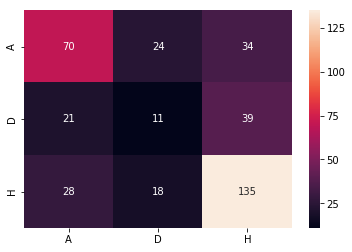

In [69]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(confusion_matrix(valid_y, y_pred), index = ['A','D',"H"], columns = ['A','D','H']),
            annot=True, fmt='g')
plt.show()